In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import requests
shp_file = gpd.read_file('datasets/geo_export_26bce2f2-c163-42a9-9329-9ca6e082c5e9.shp')
school_progress_21_22 = pd.read_csv("https://data.cityofchicago.org/resource/ngix-dc87.csv")
school_progress_22_23 = pd.read_csv("https://data.cityofchicago.org/resource/d7as-muwj.csv")
school_progress_23_24 = pd.read_csv("https://data.cityofchicago.org/resource/2dn2-x66j.csv")
crime = pd.DataFrame(requests.get("https://data.cityofchicago.org/resource/9hwr-2zxp.json").json())
data = pd.read_csv("datasets/My_CHI._My_Future._Programs.csv")


## Basic Eda
### 1. Are there any correlations between crime and availability of programs in certain districts when crime incidents happen, and more importantly, does a crime incident mean that programs are affected some considerable time after the incident? 
### 2. Is there such a thing as outlier districts that despite having high crime, they present high student attainment, high graduation rate and a great number of programs? How big of a role does crime play in access to programs and high educational attainment?


## Data preparation and cleaning

### Missing value handling

In [289]:
import geopandas as gpd
from shapely.geometry import Point
# Handle missing values
has_latlong = ~data[['Latitude', 'Longitude']].isna().all(axis=1)
has_location = ~data['Location'].isna()
location_data = data[has_latlong  | has_location]
location_data = location_data[location_data['State'] != 'KS']
# impute geographic cluster name
school_progress_21_22['date'] = pd.to_datetime('2022-09-18')
school_progress_22_23['date'] = pd.to_datetime('2023-06-06')
school_progress_23_24['date'] = pd.to_datetime('2024-10-21')
school_progress = pd.concat([school_progress_21_22, school_progress_22_23, school_progress_23_24], axis=0) # no missing zip codes, no missing latitudes and longitudes
crime.dropna(axis='rows',how='any', inplace=True) # crime only has 3 rows in which the location is missing

In [290]:
location_data = location_data.copy()
location_data.drop(['Image', 'Program URL', 'Registration URL', 'Registration Open', 
                   'Contact Phone', 'Contact Email', 'Hidden Programs', 'Featured', 
                   'Meeting Type', 'Has Free Food', 'Transport Provided', 'Participants Paid', 'Contact Name', 'Program ID', 
                   'Online Address', 'State', 'Registration Deadline', 'Scholarship Available'], 
                   axis='columns', inplace=True)

In [291]:
location_data.isna().sum()

Program Name                    0
Description                     0
Org Name                        0
Category Name                   0
Capacity                     6162
Min Age                         0
Max Age                         0
Address                         6
City                            2
ZIP Code                      103
Program Type                    0
Start Date                      0
End Date                        0
Start Time                  21339
End Time                    21349
Program Price                   0
Geographic Cluster Name      3198
Custom Categories          213115
Tag                             0
Latitude                        0
Longitude                       0
Location                        0
dtype: int64

### Impute geographic cluster name

In [292]:
shp_file.dtypes

area           float64
area_num_1      object
area_numbe      object
comarea        float64
comarea_id     float64
community       object
perimeter      float64
shape_area     float64
shape_len      float64
geometry      geometry
dtype: object

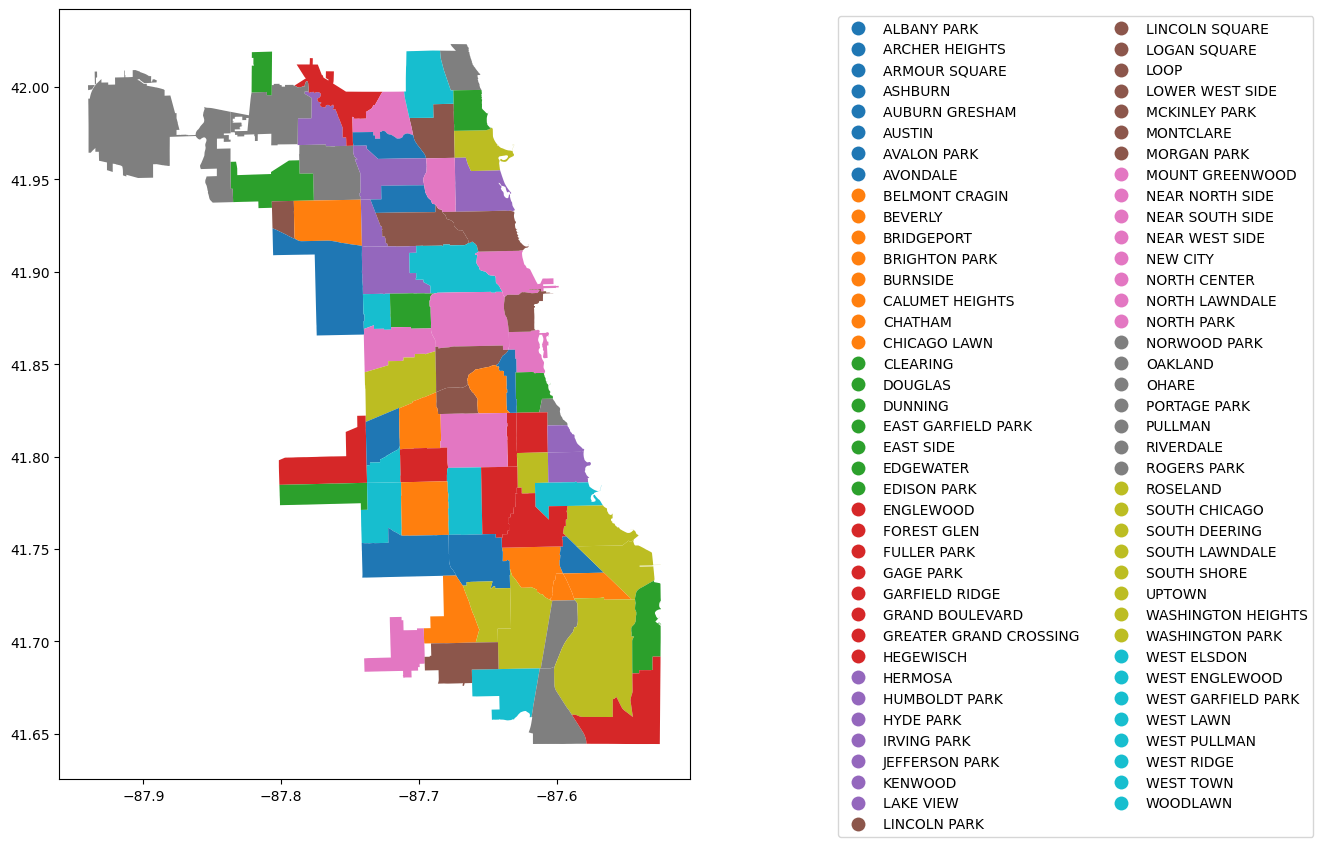

In [294]:
import geopandas as gpd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
shp_file.plot(column='community', ax=ax, legend=True, legend_kwds={'ncol': 2, 'bbox_to_anchor': (2, 1)})
plt.show()

### Merge datasets and derive additional variables

In [68]:
def create_geodataframe(data):
    """
    Create a GeoDataFrame prioritizing ZIP codes, and adding polygon shapes to points 
    that fall within ZIP boundaries.
    """
    # Read ZIP shapes first since we'll need them for both cases
    zip_shapes = gpd.read_file('datasets/geo_export_c9fbac2d-b459-4a78-b87c-12284060241a.shp')
    zip_shapes['zip'] = pd.to_numeric(zip_shapes['zip'])
    
    # Initialize variables
    zip_gdf = None
    point_gdf = None
    
    # Process ZIP code data first
    has_zip = ~data['ZIP Code'].isna()
    zip_data = data[has_zip].copy()
    if len(zip_data) > 0:
        zip_gdf = zip_shapes.merge(zip_data, left_on='zip', right_on='ZIP Code')
    
    # Process remaining points that don't have ZIP codes
    no_zip_data = data[~has_zip].copy()
    points_to_process = no_zip_data[~no_zip_data[['Latitude', 'Longitude']].isna().all(axis=1)]
    
    if len(points_to_process) > 0:
        # Create points geometry
        geometry = [Point(xy) for xy in zip(points_to_process['Longitude'], points_to_process['Latitude'])]
        point_gdf = gpd.GeoDataFrame(points_to_process, geometry=geometry)
        point_gdf.set_crs(epsg=4326, inplace=True)
        
        # Find which ZIP code polygon each point falls within
        points_with_zips = gpd.sjoin(point_gdf, zip_shapes, how='left', predicate='within')
        
        # For points that fall within a ZIP code, use the polygon geometry
        mask_within_zip = ~points_with_zips['zip'].isna()
        
        if mask_within_zip.any():
            # Points that fall within a ZIP code - use polygon geometry
            points_in_zip = points_with_zips[mask_within_zip].merge(
                zip_shapes[['zip', 'geometry']], 
                on='zip', 
                suffixes=('', '_polygon')
            )
            points_in_zip['geometry'] = points_in_zip['geometry_polygon']
            points_in_zip = points_in_zip.drop(columns=['geometry_polygon'])
            
            # Points that don't fall within any ZIP code - keep as points
            points_outside_zip = point_gdf[~point_gdf.index.isin(points_with_zips[mask_within_zip].index)]
            
            # Combine both types of points
            point_gdf = pd.concat([points_in_zip, points_outside_zip], ignore_index=True)
        
    # Combine all results
    if zip_gdf is not None and point_gdf is not None:
        return pd.concat([zip_gdf, point_gdf], ignore_index=True)
    elif zip_gdf is not None:
        return zip_gdf
    elif point_gdf is not None:
        return point_gdf
    else:
        return None

In [69]:
geo_df = create_geodataframe(location_data)

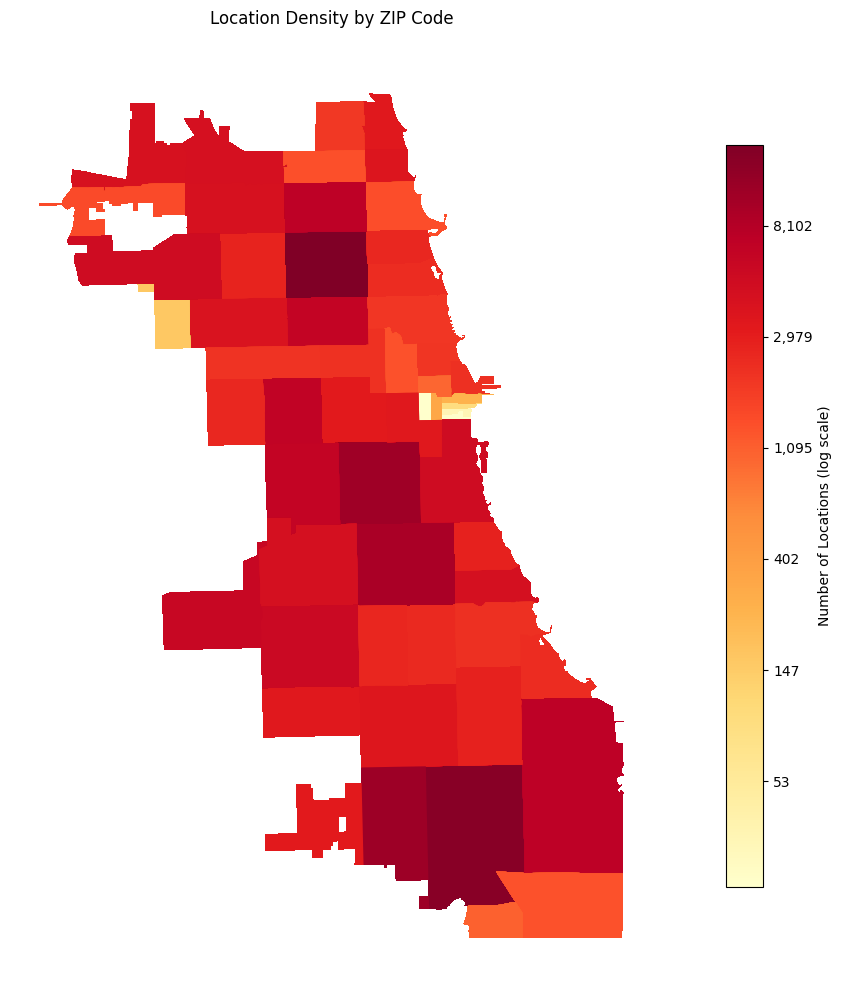

In [75]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

def plot_zip_density(gdf_shapes, data, title="Location Density Map", figsize=(15, 10)):
    """
    Create a map showing ZIP code polygons colored by frequency of occurrences
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Count occurrences of each ZIP code in the data
    zip_counts = data['ZIP Code'].value_counts().reset_index()
    zip_counts.columns = ['ZIP Code', 'count']
    
    # Merge counts with shapes
    plot_data = gdf_shapes.merge(zip_counts, left_on='zip', right_on='ZIP Code', how='left')
    plot_data['count'] = plot_data['count'].fillna(0)
    
    # Log transform for better visualization of magnitude differences
    plot_data['count_normalized'] = np.log1p(plot_data['count'])
    
    # Plot polygons colored by frequency
    plot_data.plot(
        column='count_normalized',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': 'Number of Locations (log scale)',
            'orientation': 'vertical',
            'shrink': 0.8,
            'format': lambda x, p: f'{int(np.exp(x)-1):,}'
        },
        cmap='YlOrRd',
        missing_kwds={'color': 'lightgrey'}
    )
    
    # Customize the plot
    plt.title(title, pad=20)
    ax.set_axis_off()
    
    return fig, ax

# Create the visualization
gdf_shapes = geo_df[geo_df.geometry.type == 'Polygon']
fig, ax = plot_zip_density(
    gdf_shapes,
    data,  # Your original dataframe with ZIP Code column
    title="Location Density by ZIP Code"
)
plt.tight_layout()
plt.show()